In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
from tqdm import tqdm  # for progress bar (optional)
import time
from scipy import special as sp
from scipy.interpolate import interp1d

In [33]:
# Lennard-Jones potential
def lj_potential(r):
    sigma = 3.405   # Angstrom (Ar) given in the exercise
    #epsi = 119.8 * scipy.constants.k  # Boltzmann constant times the temperature (K) given in the exercise
    epsi = 0.997
    return 4 * epsi * ((sigma / r) ** 12 - (sigma / r) ** 6)

# Function to calculate distance between two points with periodic boundary conditions
def distance(r1, r2):
    dx = r1[0] - r2[0]
    dy = r1[1] - r2[1]
    dx -= np.round(dx / L) * L
    dy -= np.round(dy / L) * L
    return np.sqrt(dx**2 + dy**2)

def TotEnergy(positions, L, N):
    E = 0
    for i in range(N):
        for j in range(i+1, N):
            r = distance(positions[i], positions[j])
            E += lj_potential(r)
    return E

# Compute radial distribution function g(r)
def calculate_radial_distribution(positions, L, dr):
    N = len(positions)
    rho = N / (L * L)
    max_bin_index = int(L / 2 / dr)
    g_values = np.zeros(max_bin_index)

    for i in range(N):
        for j in range(i+1, N):
            r = distance(positions[i], positions[j])
            if r < L / 2:
                bin_index = min(int(r / dr), max_bin_index - 1)
                g_values[bin_index] += 2  # Count each pair only once

    # Normalize g(r)
    for i in range(len(g_values)):
        r_lower = i * dr
        r_upper = (i + 1) * dr
        shell_volume = np.pi * ((r_upper)**2 - (r_lower)**2)
        g_values[i] /= shell_volume * rho * N

    r_values = np.arange(dr, (max_bin_index + 1) * dr, dr)
    return r_values, g_values

In [74]:
## PARAMETERS ##
N = 242  # Number of atoms
T = 3 # Temperature
p = 0.96  # Density
L = np.sqrt(N / p)  # Box size
D = 0.15  # Displacement amplitude
n_steps = 200000

In [75]:
# Initialize positions randomly
positions = np.random.rand(N, 2) * L

# Initialize energy
energy = 0.0

# Perform Monte Carlo steps
n_accept = np.zeros(n_steps)
E_values = []

with tqdm(total=n_steps) as pbar:
    for step in range(n_steps):
        # Randomly select an atom
        atom_index = np.random.randint(N)
        
        # Calculate energy before displacement
        old_energy = 0.0
        for i in range(N):
            if i != atom_index:
                old_energy += lj_potential(distance(positions[atom_index], positions[i]))
        
        # Propose a random displacement
        displacement = (np.random.rand(2) - 0.5) * D
        new_position = positions[atom_index] + displacement
        
        # Apply periodic boundary conditions
        new_position = np.mod(new_position, L)
        
        # Calculate energy after displacement
        new_energy = 0.0
        for i in range(N):
            if i != atom_index:
                new_energy += lj_potential(distance(new_position, positions[i]))
        
        # Metropolis criterion
        delta_energy = new_energy - old_energy
        if delta_energy < 0 or np.random.rand() < np.exp(-delta_energy / T):
            positions[atom_index] = new_position
            energy += delta_energy
            n_accept[step] = 1
        
        # Store energy
        E_values.append(energy)

        pbar.update()

100%|██████████| 200000/200000 [13:20<00:00, 249.85it/s]


Average energy: -9.520797488467983e+21
Energy standard deviation: 3.852832557120527e+20


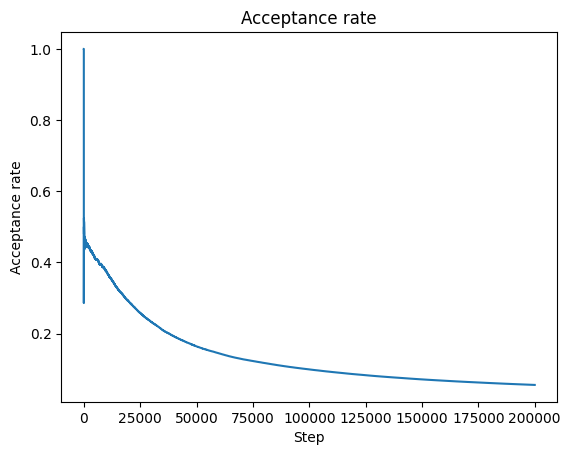

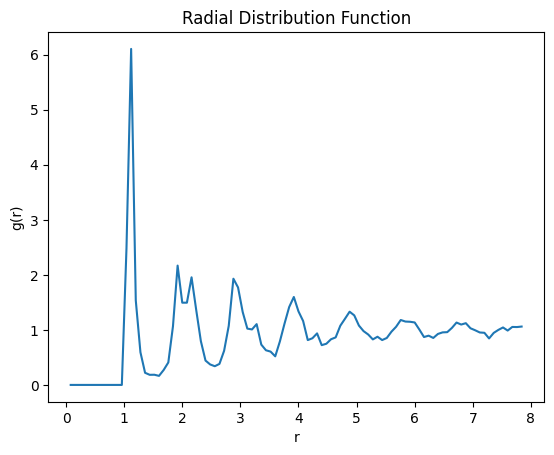

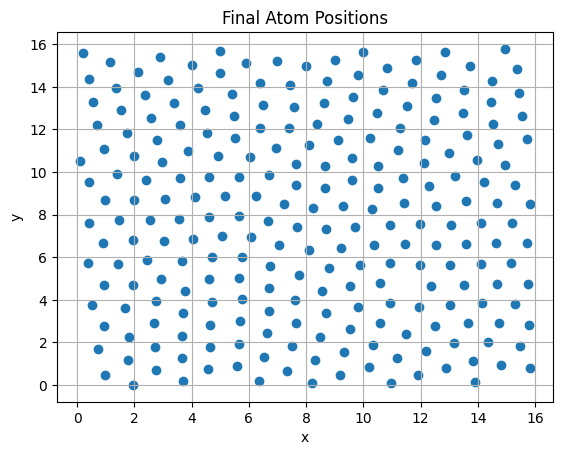

In [78]:
r_values, g_values = calculate_radial_distribution(positions, L, 0.08)

# Plot the acceptance rate
plt.figure()
plt.plot(np.cumsum(n_accept) / np.arange(1, n_steps + 1))
plt.xlabel('Step')
plt.ylabel('Acceptance rate')
plt.title('Acceptance rate')

# Compute energy and its standard deviation
E_avg = np.mean(E_values)
E_std = np.std(E_values)

print("Average energy:", E_avg)
print("Energy standard deviation:", E_std)

# Plot g(r)
plt.figure()
plt.plot(r_values[:-1], g_values[:-1])
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function')

# Plot the atom positions
plt.figure()
plt.scatter(positions[:, 0], positions[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Final Atom Positions')
plt.grid()

# Show plots
plt.show()